# Lesson 5 | Linear Models & Neural Nets from Scratch
> Building upon Lesson 3 Foundational Concepts

> Checkout this notebook in [colab](https://colab.research.google.com/github/nglillywhite/blog/blob/main/posts/2023-01-20-Fastai%20Lesson%205.ipynb)

## Lecture Content

Now since we've already worked through the [chapter 4](https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb) book content in my lesson 3 blogpost, I won't repeat the work here, [instead I'd recommend you checkout that post](https://nglillywhite.quarto.pub/nicks-blog/posts/2022-12-29-Fastai%20Lesson%203.html#book-content) if you'd like to see the book content that pairs with this week's lecture.

### Downloading Data from Kaggle

Building upon the concepts and principles we learned in lesson 3, we're going to build our neural net from scratch and run it against the titanic dataset which we can source from kaggle. We can use the python api to select the competition and download all the data to a given path like we have below

In [5]:
import os
from pathlib import Path
import kaggle
import zipfile

path = Path("../data/titanic")
path.mkdir(exist_ok=True)
kaggle.api.competition_download_cli(competition="titanic",
                                    path=path)

100%|█████████████████████████████████████████████████████████████████████████████| 34.1k/34.1k [00:00<00:00, 3.88MB/s]

Then we can extract the zip from our path to our path to unpack the contents

In [8]:
zipfile.ZipFile(f"{path}\\titanic.zip").extractall(path)

I'm just importing fastai to get the 'nice' version of Path which allows me to .ls() the directory and see whats inside

In [11]:
from fastai.vision.all import *

In [13]:
path = Path("../data/titanic")

In [14]:
path.ls()

(#4) [Path('../data/titanic/gender_submission.csv'),Path('../data/titanic/test.csv'),Path('../data/titanic/titanic.zip'),Path('../data/titanic/train.csv')]

Cool, we've got our test, train, and submission csvs as well as the original zip.

As mentioned in the lesson, we're going to import pytorch and numpy to work with arrays, and pandas for working with dataframes

In [15]:
import torch
import numpy as np
import pandas as pd

### Data Cleaning

Lets first do some data cleaning along with the course

In [18]:
df = pd.read_csv(path/"train.csv")

In [19]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


As we learned in lesson 3, we want to apply all our inputs by some weights and biases, but if we look at the 'Cabin' column there are some 'NaN' values, or "Not a Number" values, we've got to change this to something computable for our model to work. Lets checkout how many NaNs are there in the whole dataset

In [20]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Ok it looks like only Age and Cabin have NaN values that we need to handle. One strategy for imputing missing values is replacing them with the 'mode', or the most commonly occuring value already present in the array, lets checkout the mode.

In [25]:
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

We can now fill the columns with the most commonly occuring values that we grabbed from above

In [26]:
df.fillna(modes, inplace=True)

Any empties left? Lets look

In [28]:
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

The pandas describe() function is a really cool way to investigate either all or certain datatypes, combine this with numpy's types and we can get specifically all the numeric data types by using the np.number base class and the describe() method

In [31]:
np.number?

Init signature: np.number()
Docstring:      Abstract base class of all numeric scalar types.
File:           c:\users\nick\anaconda3\envs\fastai\lib\site-packages\numpy\__init__.py
Type:           type
Subclasses:     integer, inexact


In [29]:
df.describe(include=np.number)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Ok we can see that fare has 75% of fares under \\$31 but a mean of \\$32 and a max of $512, this would lead us to thinking there's quite a skewed distribution. This kind of skewness will bias our weights to these large values when we don't really want them to, lets have a look at the distribution.

<AxesSubplot: >

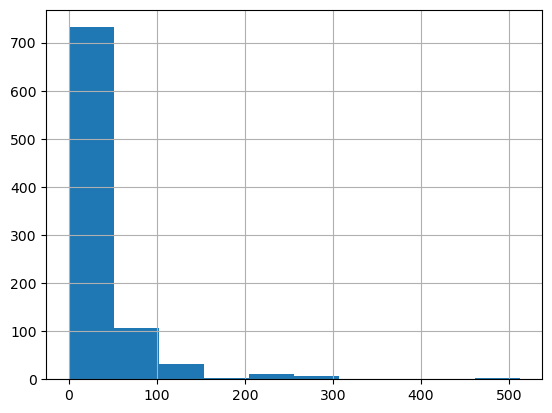

In [33]:
df.Fare.hist()

Super skewed! Almost all the values are below 50, yet we go up to ~\\$500 in this graph. What we can do to distribute these values more normally is take the log of the array which will squish down these massive numbers and not fetter with the lower values too much. Also we're adding 1 to all values since there are some 0 fares and log(0) is infinity.

In [35]:
df["LogFare"] = np.log(df.Fare+1)

<AxesSubplot: >

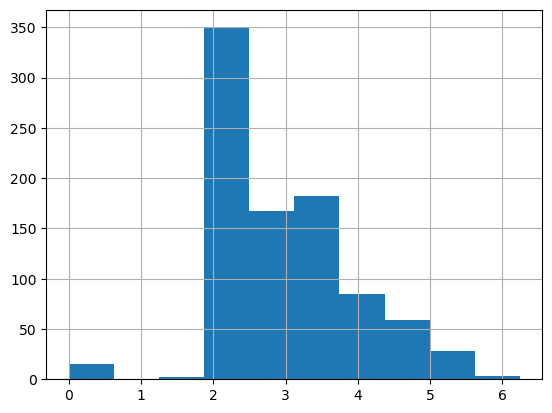

In [36]:
df.LogFare.hist()

That looks way better, sure its not perfect but everything is a more manageable value and we can definitely see a reduced skew.

Lets checkout the other columns

In [41]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,LogFare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208,2.962246
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429,0.969048
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400,2.187218
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200,2.737881
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000,3.465736
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,6.240917


PClass also seems to only have three classes, which is actually outlined to us in the competition guidelines, we could also look at the histogram to see.

<AxesSubplot: >

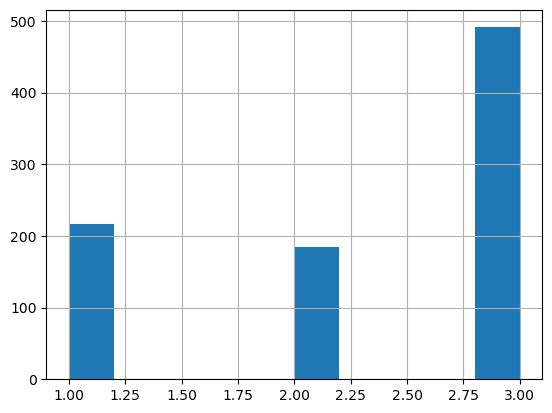

In [43]:
df.Pclass.hist()

Thats not continuous at all, we can also use the unique() method on the pandas dataframe

In [44]:
df.Pclass.unique()

array([3, 1, 2], dtype=int64)

In [45]:
pclasses = sorted(df.Pclass.unique())
pclasses

[1, 2, 3]

Ok now lets checkout the non numeric values, which we'll have to represent numerically somehow since we need to be able to multiply them by our weights and biases. A simple way to do this is one-hot-encoding them, also known as making 'dummy' values which creates a binary column each for 'n' classes and then a 0 or 1 in each column if that class is observed. You can technically do n-1 classes since if all the binary columns are 0 then you've technically observed the last column but most often you'll explicitly express each column.

In [46]:
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


In [50]:
df = pd.get_dummies(df,columns=["Sex","Pclass","Embarked"])
df.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,LogFare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,B96 B98,2.110213,0,1,0,0,1,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",38.0,1,0,PC 17599,71.2833,C85,4.280593,1,0,1,0,0,1,0,0
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,B96 B98,2.188856,1,0,0,0,1,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,3.990834,1,0,1,0,0,0,0,1
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,B96 B98,2.202765,0,1,0,0,1,0,0,1


Ok we can see some new columns being added, with the structure of 'originalColumn_classObservation', for example 'Sex_female'. Lets grab these added columns specifically.

In [58]:
new_columns = list(df.columns[10:])
df[new_columns].head()

,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,0,1,0,0,1,0,0,1
1,1,0,1,0,0,1,0,0
2,1,0,0,0,1,0,0,1
3,1,0,1,0,0,0,0,1
4,0,1,0,0,1,0,0,1


### Creating Independent & Dependent Variables

Now we've got to make our 'x' (Independent / Predictors) and 'y' (Dependent / Target) tensors for us to train and predict with. We're trying to predict if someone survived so "Survived" is our y value.

In [59]:
from torch import tensor

t_dep = tensor(df.Survived)

Our x values are all the continues values we can grab as well as the dummy values we made.

In [61]:
independent_cols = ['Age', "SibSp", "Parch", "LogFare"] + new_columns

t_independent = tensor(df[independent_cols].values, dtype=torch.float)
t_independent

tensor([[22.,  1.,  0.,  ...,  0.,  0.,  1.],
        [38.,  1.,  0.,  ...,  1.,  0.,  0.],
        [26.,  0.,  0.,  ...,  0.,  0.,  1.],
        ...,
        [24.,  1.,  2.,  ...,  0.,  0.,  1.],
        [26.,  0.,  0.,  ...,  1.,  0.,  0.],
        [32.,  0.,  0.,  ...,  0.,  1.,  0.]])

In [62]:
t_independent.shape

torch.Size([891, 12])

Ok so we've got our 891 observations of 12 columns / attributes / features to work with.

### Building our Linear Model

We will first build a totally linear model without any non-linear activation functions like a ReLu (That we worked through in Lesson 3), to do this we'll get a coefficient for each independent variable (column/feature) by picking a random value in the range of (-5,5).

In [63]:
torch.manual_seed(26)

n_coefficients = t_independent.shape[1]
coefficients = torch.rand(n_coefficients)-0.5
coefficients

tensor([ 0.3313,  0.0565,  0.4642, -0.0014,  0.1842, -0.3090, -0.4595, -0.0689,
         0.3639,  0.2758, -0.3921,  0.3848])

Looks pretty random to me. We're going to multiply all our coefficients with our x values and add them up. Lets do that

In [64]:
t_independent*coefficients

tensor([[ 7.2897,  0.0565,  0.0000,  ...,  0.0000, -0.0000,  0.3848],
        [12.5912,  0.0565,  0.0000,  ...,  0.2758, -0.0000,  0.0000],
        [ 8.6150,  0.0000,  0.0000,  ...,  0.0000, -0.0000,  0.3848],
        ...,
        [ 7.9523,  0.0565,  0.9284,  ...,  0.0000, -0.0000,  0.3848],
        [ 8.6150,  0.0000,  0.0000,  ...,  0.2758, -0.0000,  0.0000],
        [10.6031,  0.0000,  0.0000,  ...,  0.0000, -0.3921,  0.0000]])

Our first column age is simply a lot bigger than all our other columns and is dominating the output, we can normalise the values between 0 and 1 for all columns so that no particular nominal size of values for any column is bigger than another. We can use sigmoid or simply divide by the maximum of the column to do this normalisation.

In [65]:
vals, indices = t_independent.max(dim=0)
vals, indices

(tensor([80.0000,  8.0000,  6.0000,  6.2409,  1.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  1.0000,  1.0000]),
 tensor([630, 159, 678, 258,   1,   0,   1,   9,   0,   1,   5,   0]))

You can see that we have the maximum for each column, and the index of where that value occured, lets now normalise those independant/x values

In [67]:
t_independent = t_independent / vals
t_independent

tensor([[0.2750, 0.1250, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
        [0.4750, 0.1250, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.3250, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.3000, 0.1250, 0.3333,  ..., 0.0000, 0.0000, 1.0000],
        [0.3250, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.4000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000]])

In [68]:
t_independent*coefficients

tensor([[ 0.0911,  0.0071,  0.0000,  ...,  0.0000, -0.0000,  0.3848],
        [ 0.1574,  0.0071,  0.0000,  ...,  0.2758, -0.0000,  0.0000],
        [ 0.1077,  0.0000,  0.0000,  ...,  0.0000, -0.0000,  0.3848],
        ...,
        [ 0.0994,  0.0071,  0.1547,  ...,  0.0000, -0.0000,  0.3848],
        [ 0.1077,  0.0000,  0.0000,  ...,  0.2758, -0.0000,  0.0000],
        [ 0.1325,  0.0000,  0.0000,  ...,  0.0000, -0.3921,  0.0000]])

Awesome, everything is looking far more balanced now.

The course makes a great note to highlight the vector by matrix calculations we're running here. Note that 't_independent' is a matrix and coefficients is a vector of values, even though we're simply saying multiply each other, pytorch knows to broadcast the vector over the whole matrix for the calculations. Definitely checkout lesson 3 / chapter 4 of the book to learn more about this. I've also linked some decent broadcasting documentation there as well.

Ok lets now make our predictions

In [70]:
preds = (t_independent*coefficients).sum(axis=1)
preds[:10], preds.shape

(tensor([ 0.5373,  0.1640,  1.0401,  0.2606,  0.5841, -0.2383, -0.1610,  0.5458,
          1.1989,  0.4553]),
 torch.Size([891]))

### Building a Loss Function

As with lesson 3, we need a way to optimise those coefficients/weights and we do that via calculating a loss and gradients which we then multiply by a learning rate to move our coefficients/weights to a more effective value. Lets do that now.

In [71]:
loss = torch.abs(preds-t_dep).mean()
loss

tensor(0.5372)

We've taken the absolute error of our predictions minus the true value and then grabbed the mean(). We're pretty close to random chance at .53 since there can only be a 0 or 1 value.

Lets wrap calculating the predictions and losses in some helper functions and keep moving.

In [72]:
def calculate_preds(coefficients, independent_variables): return (independent_variables*coefficients).sum(axis=1)
def calculate_loss(coefficients, independent_variables, dependent_variables): return torch.abs(calculate_preds(coefficients, independent_variables)-dependent_variables).mean()

### Gradient Descent

Here we're going to manually do gradient descent, or a single 'epoch' of training. Pytorch will automatically track our gradients for us with the 'requires_grad_()' attribute on our coefficients so we don't have to manually set them but you can handle this manually if you wish (which we did in lesson 3).

In [73]:
coefficients.requires_grad_()

tensor([ 0.3313,  0.0565,  0.4642, -0.0014,  0.1842, -0.3090, -0.4595, -0.0689,
         0.3639,  0.2758, -0.3921,  0.3848], requires_grad=True)

In [74]:
loss = calculate_loss(coefficients, t_independent, t_dep)
loss

tensor(0.5372, grad_fn=<MeanBackward0>)

loss.backward() will ask pytorch to calculate the gradients on our coefficients

In [75]:
loss.backward()

In [76]:
coefficients.grad

tensor([ 0.0012,  0.0146,  0.0075, -0.0405, -0.0898,  0.1448, -0.2334,  0.0045,
         0.2840, -0.0718, -0.0662,  0.1930])

Gradients for free! So cool, Pytorch will add the gradients anytime our coefficients are involved in a function and calculate them for us, it will simply add them to the .grad attribute. Lets calculate the loss again and see them double 

In [77]:
loss = calculate_loss(coefficients,t_independent, t_dep)
loss.backward()
coefficients.grad

tensor([ 0.0023,  0.0292,  0.0150, -0.0810, -0.1796,  0.2896, -0.4669,  0.0090,
         0.5679, -0.1437, -0.1324,  0.3861])

Perfect, lets now modify our coefficients and zero out our gradients so that they don't keep blowing up/doubling as we keep calculating. Lets also introduce our learning rate that will decide by how much to step our weights against the gradients. We're going to modify our coefficients by subtracting the gradients by the learning rate

In [78]:
learning_rate = 0.1

loss = calculate_loss(coefficients, t_independent, t_dep)
loss.backward()
with torch.no_grad():
    coefficients.sub_(coefficients.grad * learning_rate)
    coefficients.grad.zero_()
    print(calculate_loss(coefficients, t_independent, t_dep))

tensor(0.4774)


Our loss went down to .4774 from .5372, its working! We're heading in the right direction

### Training the Linear Model

As we worked through in lesson 3, we need to setup a validation set in order to see how well we're performing on data that we haven't seen, but this is separate from our test set which we keep separate until the very end. We can use the fastai RandomSplitter and simply use a random split in this case.

In [79]:
from fastai.data.transforms import RandomSplitter

train_split, validation_split = RandomSplitter(seed=26)(df)

In [80]:
train_split, validation_split

((#713) [415,655,160,258,8,79,162,128,824,82...],
 (#178) [443,399,827,171,352,505,718,396,374,633...])

RandomSplitter will give us back a bunch of indices representing the splits, we simply need to index on those rows to get the equivalent datasets

In [81]:
train_independent, validation_independent = t_independent[train_split], t_independent[validation_split]
train_dependent, validation_dependent = t_dep[train_split], t_dep[validation_split]

len(train_independent), len(validation_independent)

(713, 178)

Lets create some functions for the three steps we just did:

1. Updating our coefficients (weights)
2. Doing a gradient descent step
3. Initialising coefficients to random numbers

In [82]:
def update_coefficients(coefficients, learning_rate):
    coefficients.sub_(coefficients.grad * learning_rate)
    coefficients.grad.zero_()
    
def one_epoch(coefficients, learning_rate):
    loss = calculate_loss(coefficients, train_independent, train_dependent)
    loss.backward()
    with torch.no_grad(): update_coefficients(coefficients, learning_rate)
    print(f"{loss:.3f}", end="; ")
    
def initialise_coefficients(): return (torch.rand(n_coefficients)-0.5).requires_grad_()

Now we have everything to train our model over many epochs, lets build a train_model method that allows us to package all this up together.

In [83]:
def train_model(epochs=30, learning_rate=0.01):
    torch.manual_seed(26)
    coefficients = initialise_coefficients()
    for i in range(epochs): one_epoch(coefficients, learning_rate=learning_rate)
    return coefficients

All wired together, lets fire it up

In [84]:
coefficients = train_model(18, learning_rate=0.2)

0.539; 0.497; 0.461; 0.429; 0.397; 0.367; 0.339; 0.319; 0.321; 0.317; 0.331; 0.314; 0.332; 0.310; 0.330; 0.306; 0.332; 0.301; 

From .539 error all the way down to .301, consistent and deliberate progress, good stuff.

Now considering we have a coefficient for each column, we can look at the coefficients and infer some knowledge of how each feature impacted someone's chances for survival

In [85]:
dict(zip(independent_cols, coefficients.requires_grad_(False)))

{'Age': tensor(0.3461),
 'SibSp': tensor(0.0012),
 'Parch': tensor(0.3972),
 'LogFare': tensor(0.1611),
 'Sex_female': tensor(0.4428),
 'Sex_male': tensor(-0.3775),
 'Pclass_1': tensor(-0.0191),
 'Pclass_2': tensor(0.0119),
 'Pclass_3': tensor(0.0329),
 'Embarked_C': tensor(0.3212),
 'Embarked_Q': tensor(-0.1801),
 'Embarked_S': tensor(0.3174)}

In [103]:
def show_coefficients(): return dict(zip(independent_cols, coefficients.requires_grad_(False)))

How cool is that, we can see each column and the literal impact of increasing or decreasing each value on the survival of the person observed in the dataset.

Lets move on to measuring accuracy since we're currently using absolute error whereas the competition actually uses accuracy.

### Measuring Accuracy

Lets get our predictions first

In [86]:
preds = calculate_preds(coefficients, validation_independent)

Lets make the assumption that any passenger over 0.5 is predicted to survive, any prediction over 0.5 where the individual survived is correct in this case

In [87]:
results = validation_dependent.bool() == (preds>0.5)
results[:10]

tensor([ True,  True, False,  True,  True,  True,  True, False, False,  True])

Lets checkout the average accuracy over the whole set

In [88]:
results.float().mean()

tensor(0.7809)

78% accuracy considering we have only have 12 coefficients and a linear function is kind of amazing. Lets define a nice accuracy helper function so we can re-calculate this anytime

In [100]:
def accuracy(coefficients): return (validation_dependent.bool() == (calculate_preds(coefficients, validation_independent) > 0.5)).float().mean()

In [92]:
preds.min(), preds.max()

(tensor(-0.3649), tensor(1.3972))

We do however have the problem of both below 0 and above 1 predictions which make no sense since 0 and 1 are limits. There's a magical function call sigmoid that provides a way to smooth all our predictions between 0 and 1, lets do it!

### Using Sigmoid

Sigmoid lets us nicely smooth everything between 0 and 1 whilst never actually reaching either, lets have a look at the function visually

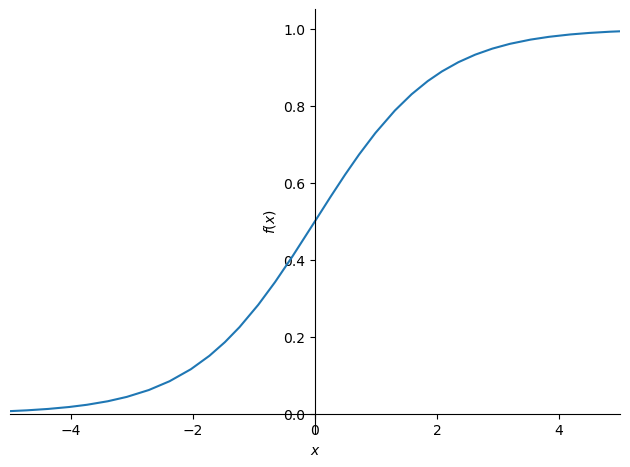

In [93]:
import sympy
sympy.plot("1/(1+exp(-x))",xlim=(-5,5))

We're using this cool library called sympy which allows us to write an expression like we did above and have it nicely plotted. Similar to the plot_function() method from fastai but a whole library.

In [95]:
doc(sympy)

Pytorch already has sigmoid out the box so we don't have to write up a custom method, it'll do the awesome math on our GPU, all parallel and quick. Lets redefine our calculate_predictions method to include this.

In [97]:
def calculate_preds(coefficients, independents): return torch.sigmoid((independents*coefficients).sum(axis=1))

Lets retrain our model to see if our loss has improved with our sigmoid function.

In [98]:
coefficients = train_model(learning_rate=50)

0.521; 0.292; 0.219; 0.217; 0.215; 0.213; 0.211; 0.210; 0.209; 0.208; 0.207; 0.206; 0.205; 0.205; 0.204; 0.204; 0.203; 0.203; 0.203; 0.203; 0.202; 0.202; 0.202; 0.202; 0.201; 0.201; 0.201; 0.201; 0.201; 0.201; 

By quite a margin, lets now checkout the accuracy

In [101]:
accuracy(coefficients)

tensor(0.8371)

~83% is certainly better for basically just smoothing out our predictions, awesome stuff. Lets checkout our coefficients again

In [105]:
show_coefficients()

{'Age': tensor(-0.1973),
 'SibSp': tensor(-1.5336),
 'Parch': tensor(-0.7395),
 'LogFare': tensor(0.1039),
 'Sex_female': tensor(5.5895),
 'Sex_male': tensor(-6.1751),
 'Pclass_1': tensor(1.8641),
 'Pclass_2': tensor(1.8072),
 'Pclass_3': tensor(-4.2965),
 'Embarked_C': tensor(0.8785),
 'Embarked_Q': tensor(1.7818),
 'Embarked_S': tensor(-2.8526)}

### Moving to Matrix Products

We've been doing vector to matrix calculations, where we have to sum all the rows over axis '1' to get our results, we can instead run a matrix multiplication on the vector by matrix and it will broadcast the vector over the entire matrix to achieve the same thing. We simply need to change our '*' operator to a '@' operator

In [110]:
(validation_independent*coefficients).sum(axis=1), ((validation_independent*coefficients).sum(axis=1)).sum()

(tensor([  4.5189,   4.5185,  -3.6778,  -9.5330,  -9.9099,  -3.5904,  -8.7023,
          -1.5997,  -2.2138,  -7.2228, -13.3593,   4.5212,  -7.3525,  -7.6108,
           2.8706, -13.3393,  -7.4905,  -7.2564,  -7.2358,  -3.4341,  -3.6701,
          -8.9045, -13.3738, -14.1698, -13.3469,  -7.1682,  -1.5776,  -9.9207,
           4.4992, -13.3319,   8.2373, -13.6142,   4.5131,  -1.5741,  -7.2383,
          -9.6171,  -3.4187,  -9.5704,   4.3943,   8.1180, -13.5418,   4.2315,
         -13.3382,  -7.2183, -13.3312,   3.0646, -13.5579,  -3.7432,  -7.4114,
          -3.4149,  -7.3426, -13.4416,   3.8130,   8.1548,   4.3626,  -7.2589,
          -7.2604,  -2.2993,  -9.6171,  -7.3642, -13.3372,  -7.2307, -13.3713,
           7.7432, -13.3467,  -7.2588,  -7.2451,   3.0518, -13.3274, -13.3445,
          -2.2153, -13.3678,  -3.5231,  -7.2613,   4.3899,   4.5091,  -9.5281,
          -8.6952, -13.3456, -13.3467,  -9.6155,  -1.7632,  -7.6220,  -8.8870,
           4.6027,  -7.2358,  -1.8948,   3.0644, -13

In [111]:
validation_independent@coefficients, (validation_independent@coefficients).sum()

(tensor([  4.5189,   4.5185,  -3.6778,  -9.5330,  -9.9099,  -3.5904,  -8.7023,
          -1.5997,  -2.2138,  -7.2228, -13.3593,   4.5212,  -7.3525,  -7.6108,
           2.8706, -13.3393,  -7.4905,  -7.2564,  -7.2358,  -3.4341,  -3.6701,
          -8.9045, -13.3738, -14.1698, -13.3469,  -7.1682,  -1.5776,  -9.9207,
           4.4992, -13.3319,   8.2373, -13.6142,   4.5131,  -1.5741,  -7.2383,
          -9.6171,  -3.4187,  -9.5704,   4.3943,   8.1180, -13.5418,   4.2315,
         -13.3382,  -7.2183, -13.3312,   3.0646, -13.5579,  -3.7432,  -7.4114,
          -3.4149,  -7.3426, -13.4416,   3.8130,   8.1548,   4.3626,  -7.2589,
          -7.2604,  -2.2993,  -9.6171,  -7.3642, -13.3372,  -7.2307, -13.3713,
           7.7432, -13.3467,  -7.2588,  -7.2451,   3.0518, -13.3274, -13.3445,
          -2.2153, -13.3678,  -3.5231,  -7.2613,   4.3899,   4.5091,  -9.5281,
          -8.6952, -13.3456, -13.3467,  -9.6155,  -1.7632,  -7.6220,  -8.8870,
           4.6027,  -7.2358,  -1.8948,   3.0644, -13

We produce the identical tensor and total but this is more efficient since we're able to run these calculations in parallel on the GPU, lets modify our calculate_preds() again to reflect this

In [112]:
def calculate_preds(coefficients, independents): return torch.sigmoid(independents@coefficients)

The only other thing we need to do is convert our vector to a matrix with a single column and 'transpose' it so that its a matrix by matrix calculation instead of a matrix by vector

In [113]:
def initialise_coefficients(): return (torch.randn(n_coefficients, 1)*0.1).requires_grad_()

In [114]:
initialise_coefficients()

tensor([[ 0.0634],
        [-0.0220],
        [-0.0140],
        [-0.0766],
        [ 0.0887],
        [ 0.0815],
        [ 0.0809],
        [ 0.0619],
        [-0.0255],
        [ 0.0457],
        [ 0.0780],
        [ 0.0032]], requires_grad=True)

See how we now have a single column matrix instead of the previous vector, we'll have to transform the same for our dependent sets

In [115]:
train_dependent = train_dependent[:,None]
validation_dependent = validation_dependent[:,None]

In [116]:
coefficients = train_model(learning_rate=50)

0.483; 0.305; 0.222; 0.212; 0.210; 0.209; 0.208; 0.207; 0.206; 0.205; 0.205; 0.204; 0.204; 0.203; 0.203; 0.203; 0.202; 0.202; 0.202; 0.202; 0.201; 0.201; 0.201; 0.201; 0.201; 0.201; 0.200; 0.200; 0.200; 0.200; 

In [117]:
accuracy(coefficients)

tensor(0.8371)

And we have the same model and output, awesome. Lets now move to making a neural net as we have all the pieces and tools we need to do so

### Neural Networks

We will need a few things:

 - Coefficients (weights/parameters) for each of our layers
 - A number of 'hidden' layers of various sizes (model architecture)
 - A final output layer (prediction output / model head)
 
We will control a few of these parameters by creating variables we set such as n_hidden, n_coefficients etc, lets get started

In [118]:
def initialise_coefficients(n_hidden=20):
    layer1 = (torch.rand(n_coefficients, n_hidden)-0.5)/n_hidden
    layer2 = torch.rand(n_hidden, 1)-0.3
    const = torch.rand(1)[0]
    return layer1.requires_grad_(), layer2.requires_grad_(), const.requires_grad_()

Ok so we have our coefficients for each of our layers, we have a constant bias term, we can now make our neural network by handcrafting our layers and adding our non-linearities in between them before finally passing to sigmoid for our predictions.

In [119]:
import torch.nn.functional as F

def calculate_preds(coefficients, independents):
    l1, l2, const = coefficients
    res = F.relu(independents@l1)
    res = res@l2 + const
    return torch.sigmoid(res)

Ok see here how we're grabbing our layers, multiplying the independents by the first layer, multiplying that result by a relu activation (non-linearity is introduced here) and then finally multiplying by our final layer and adding our constant term. We then have our output which we can sigmoid to get our final prediction.

We also need to write our method to update the coefficients by calculating the gradients for each layer, subtracting them by the learning rate and zeroing out the gradients to be calculated in the next batch/epoch.

In [120]:
def update_coefficients(coefficients, learning_rate):
    for layer in coefficients:
        layer.sub_(layer.grad * learning_rate)
        layer.grad.zero_()

We've got everything together, lets quickly checkout our layers, remembering there's a relu inbetween the layers and we have our final constant term

In [127]:
layer1, layer2, const = initialise_coefficients()

In [128]:
layer1.shape, layer2.shape, const

(torch.Size([12, 20]), torch.Size([20, 1]), tensor(0.8732, requires_grad=True))

Layer one takes in our 12 'x' values as the independent variables, outputs a shape of 20 which our next layer takes in and then condenses to 1 output which we sigmoid for our prediction. Hopefully these shapes make sense, and that bigger architectures are just more complicated connections between these matrices of different sizes and shapes which are suited better to particular problems.

Ok lets train our model:

In [121]:
coefficients = train_model(learning_rate=1.4)

0.525; 0.503; 0.485; 0.465; 0.440; 0.412; 0.382; 0.352; 0.325; 0.304; 0.287; 0.275; 0.265; 0.257; 0.250; 0.245; 0.241; 0.238; 0.235; 0.233; 0.231; 0.229; 0.227; 0.226; 0.225; 0.223; 0.222; 0.221; 0.220; 0.219; 

In [122]:
coefficients = train_model(learning_rate=20)

0.525; 0.372; 0.249; 0.314; 0.220; 0.202; 0.200; 0.199; 0.198; 0.198; 0.197; 0.196; 0.196; 0.196; 0.196; 0.196; 0.196; 0.196; 0.196; 0.196; 0.196; 0.196; 0.196; 0.196; 0.196; 0.195; 0.195; 0.195; 0.195; 0.195; 

In [123]:
accuracy(coefficients)

tensor(0.8371)

Well our loss is definitely better at 0.195 but our accuracy is still the same which is interesting, whilst we haven't blown away our linear model, its really cool to see how only a couple of layers of matrices can give effective results.

### Making the Neural Net 'Deep'

Now whilst the universal approximation paper says that two layers is all you need to approximate any function in the universe (a terrible paraphrase of what the paper says), its not very practical in the real world. It also isn't very 'deep' since we only have two layers, by building more layers, we make our network 'deep', hence the name. Again we need to connect layer to layer with activations in between, lets do it.

Note that the sizes variables is our 'crude' model architecture, simply the structure of all the hidden layers (the model body) and the final output layer which spits out predictions is the (model head)

In [275]:
def initialise_coefficients():
    hiddens=[12,5,12,5]
    sizes = [n_coefficients] + hiddens + [1]
    n =  len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n-1)]
    consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
    for l in layers+consts: l.requires_grad_()
    return layers, consts

As Jeremy notes in the course, there are lots of fiddly constants here, the initialisation of weights has drastic impacts on the training progress of your model, there are ways to address this which we'll work on later through the course but its important to note these aren't accidental and are part of the difficult nature of this type of model.

We'll also re-define our calculate predictions method and loop through each layer instead of explicitly calling them

In [276]:
def calculate_preds(coefficients, independents):
    layers, consts = coefficients
    n = len(layers)
    res = independents
    for iteration, layer in enumerate(layers):
        res = res@layer + consts[iteration]
        if iteration!=n-1: res = F.relu(res)
    return torch.sigmoid(res)

Check it out, the line **res = res@layer + consts[i]** is our $prediction = weights * inputs + bias$ or $y = mx + b$ equation from lesson 3. Still blows my mind that these simple equations can be built up into such flexible models that are truly effective at solving problems.

We also need to update our coefficients updating method since we've got many layers and constants rather than explicit setups

In [277]:
def update_coefficients(coefficients, learning_rate):
    layers, consts = coefficients
    for layer in layers+consts:
        layer.sub_(layer.grad*learning_rate)
        layer.grad.zero_()

And back to training our model

In [281]:
coefficients = train_model(learning_rate=12)

0.566; 0.476; 0.443; 0.423; 0.412; 0.406; 0.402; 0.399; 0.397; 0.395; 0.394; 0.393; 0.392; 0.391; 0.391; 0.390; 0.390; 0.390; 0.389; 0.389; 0.389; 0.389; 0.388; 0.388; 0.388; 0.388; 0.388; 0.388; 0.387; 0.387; 

In [282]:
accuracy(coefficients)

tensor(0.6180)

Ok maybe this model architecture wasn't as great as our two layers but its still cool to see how we can 'artisinally' create our layers and whats happening within each layer. This was a really interesting 'double up' on lesson 3 which covers the same chapter 4 of the book. I'm feeling very confident in the raw mechanices of how these models function which is fantastic. On to lesson 6 and thanks for reading if you're here with me.